In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'email-spam-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3962399%2F6897944%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T051820Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D515ed43918dae86431dfdc062f58acca7046bfd2911e5635c427bb133a92ce21c8f4ab81981f99762ee4c583d346b29c14e57fa74604b44014daea7cb4d75d6cfee77564b011ed3409d9d6242df738aba0833be64a2320767c3a91fcca02ae31b47c9bc77570acfe2eef554354c2b23ce6727a605e6c4c4e0aed16feff074fca894a86ba6679141d4f7b495411ea29126391ef418f6b3f40797f4315e22455c7aeea48e5671b9c195aab67b4baf89b5760d1518e7eec24dcfc11231931a79b343adfb08a6a73c8583486aecc1eb7e469d5d3cf06815631001f79205cfa6cbe4f00c954408c7b4d9355db727cf86a9b37c1a7f68333bd70a3f0315e8d94c7c037'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 45062184 bytes downloaded
Downloaded and uncompressed: email-spam-classification-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf

from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df=pd.read_csv("/kaggle/input/email-spam-classification-dataset/combined_data.csv")
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [4]:
print(df.isnull().sum())

label    0
text     0
dtype: int64


In [5]:
df.shape

(83448, 2)

In [6]:
df['text'] = df['text'].str.lower()

In [7]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_special_characters)

In [9]:
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

df['text'] = df['text'].apply(word_tokenize)

df['text'] = df['text'].apply(remove_stop_words)

df['text'] = df['text'].apply(' '.join)

In [10]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

In [11]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations con

In [12]:
for i in range (1,3):
    print("Email #"+str(i))
    legitimate_email = df[df['label'] == 0]['text'].iloc[i]
    print(legitimate_email+"\n")

Email #1
thanks answers guys know checked rsync manual would rather get escapenumber sure answer one current script bin bash rsync avt exclude alpha exclude arm exclude hppa exclude hurd exclude iaescapenumber exclude mescapenumberk exclude mips exclude mipsel exclude multi arch exclude powerpc exclude sescapenumber exclude sh exclude sparc exclude source ftp de debian org debian cd var www mirror debian cd know loads excludes include distros soon rsync manual del alias delete delete delete extraneous files dest dirs delete receiver deletes transfer default delete receiver deletes xfer delete receiver deletes transfer delete excluded also delete excluded files dest dirs delete would suggest use thanks john escapelong escapenumber escapenumber escapenumber olleg samoylov wrote jonathan escapelong wrote sorry banal question favourite keys escapenumber stage rsync rsync verbose recursive links hard links times filter r tmp delete delay updates source url destination log file olleg samoylo

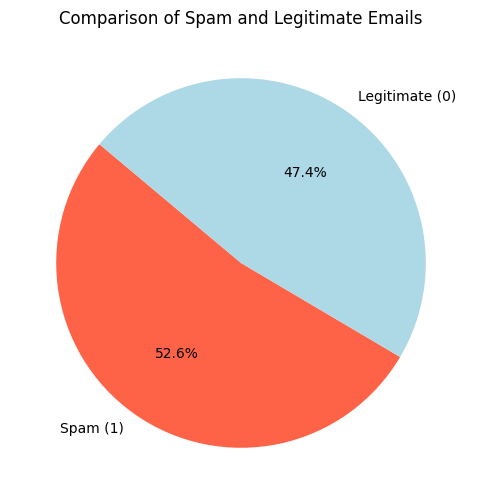

In [13]:
email_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Legitimate (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Legitimate Emails')
plt.show()

In [14]:
spam_emails = df[df['label'] == 1]['text']
legit_emails = df[df['label'] == 0]['text']

spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Legitimate Emails')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

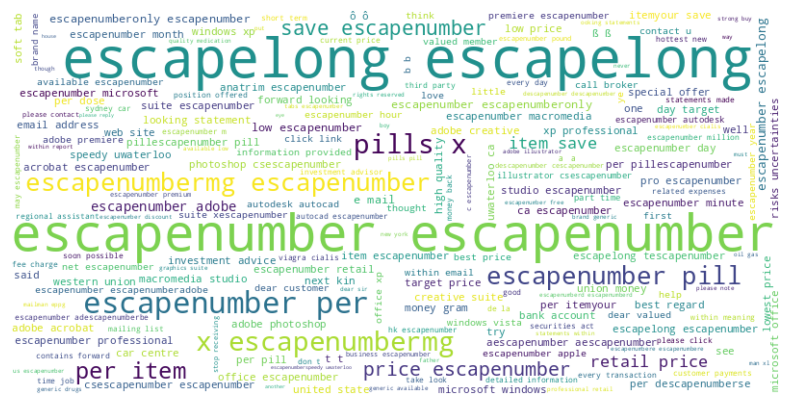

In [16]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

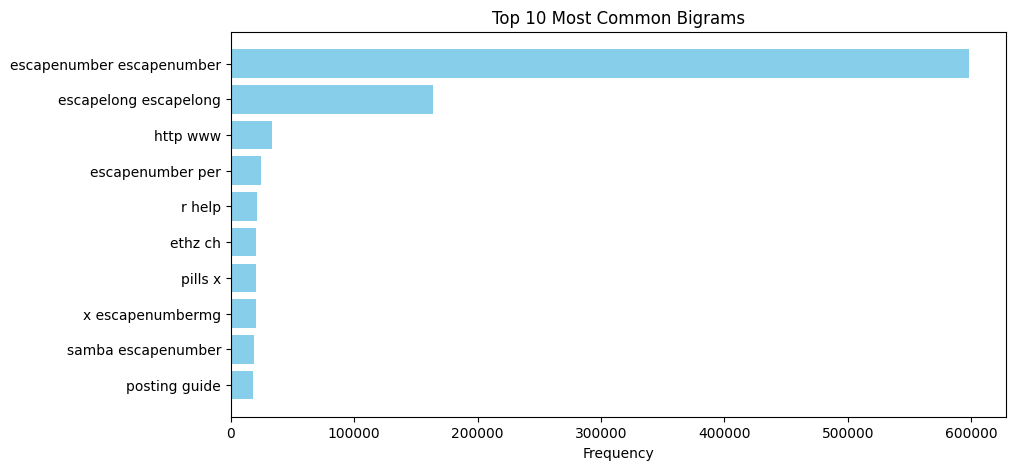

In [17]:
def generate_ngrams(text, n=2):
    words = text.split()
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

df['bigrams'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

bigram_counts = Counter([bigram for sublist in df['bigrams'] for bigram in sublist])

most_common_bigrams = bigram_counts.most_common(10)

bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()
plt.show()

In [18]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [20]:
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1305.4409692263446


In [21]:
max_length = 500

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [22]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [23]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 211745 (827.13 KB)
Trainable params: 211745 (827.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/20
 20/115 [====>.........................] - ETA: 5:44 - loss: 0.0455 - accuracy: 0.9883

In [ ]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

In [ ]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

In [ ]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);